In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import numpy as np
import pandas as pd
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input,Conv2D,MaxPooling2D,Dropout,UpSampling2D,concatenate,BatchNormalization,Add,Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import os

Using TensorFlow backend.


In [31]:
def get_proba_train(extractor, model, data, label):
    feature = extractor.predict(data)
    model.fit(feature, label)
    proba= model.predict_proba(feature)
    return proba, model

In [32]:
def get_proba_test(extractor, trained_model, data):
    feature = extractor.predict(data)
    proba= trained_model.predict_proba(feature)
    return proba

In [17]:
def get_feature(proba_array, metafile):
    df = pd.read_csv(metafile)
    dx_type = np.array(pd.get_dummies(df.dx_type))
    localization = np.array(pd.get_dummies(df.localization))
    sex = np.array(pd.get_dummies(df.sex))
    feature = np.concatenate((dx_type, localization, sex,proba_array), axis = 1)
    return feature

In [61]:
vgg_model = load_model('vgg.h5')

In [62]:
vggextract = Model(inputs=vgg_model.input,outputs=vgg_model.get_layer('dense_4').output)

In [63]:
incept_model = load_model('inception.h5')

In [64]:
inceptextract = Model(inputs=incept_model.input,outputs=incept_model.get_layer('dense_2').output)

In [65]:
X_train = np.load('rgb_train.npy')
X_test = np.load('rgb_val.npy')

In [66]:
from sklearn import preprocessing
y_train = np.array(pd.read_csv('labels_train.csv')['labels'])
y_test = np.array(pd.read_csv('labels_val.csv')['labels'])

le = preprocessing.LabelEncoder()
le.fit(y_train)
newy_train = le.transform(y_train)
le.fit(y_test)
newy_test = le.transform(y_test)



In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(max_depth=50)
SVM = LinearSVC()
LR = LogisticRegression()


In [68]:
train_vgg_proba, trained_model = get_proba_train(vggextract, LR, X_train, newy_train)
test_vgg_proba = get_proba_test(vggextract, trained_model, X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [69]:
train_incep_proba, trained_model = get_proba_train(inceptextract, RF, X_train, newy_train)
test_incep_proba = get_proba_test(inceptextract, trained_model, X_test)


In [70]:
train_feature= get_feature(np.concatenate((train_incep_proba, train_vgg_proba), axis = 1), 'meta_train.csv')
test_feature= get_feature(np.concatenate((test_incep_proba, test_vgg_proba), axis = 1), 'meta_test.csv')


In [71]:
from sklearn.metrics import classification_report
SVM.fit(train_feature, newy_train)
SVM_prediction= SVM.predict(test_feature)
SVM_prediction= le.inverse_transform(SVM_prediction)
report = classification_report(y_test, SVM_prediction)
print(report)

              precision    recall  f1-score   support

       akiec       0.59      0.50      0.54       108
         bcc       0.66      0.74      0.70       157
         bkl       0.64      0.54      0.59       382
          df       0.85      0.52      0.65        44
         mel       0.59      0.53      0.55       375
          nv       0.89      0.94      0.91      2201
        vasc       0.86      0.82      0.84        38

    accuracy                           0.81      3305
   macro avg       0.73      0.65      0.68      3305
weighted avg       0.81      0.81      0.81      3305



<AxesSubplot:>

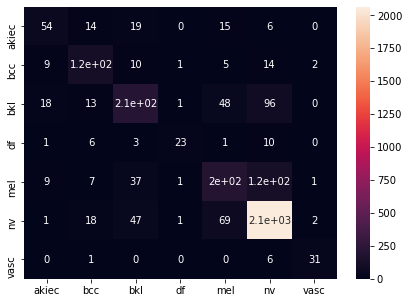

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
label = le.inverse_transform([0,1,2,3,4,5,6])
cm = confusion_matrix(y_test, SVM_prediction)
cm_df = pd.DataFrame(cm,label,label)                      
plt.figure(figsize=(7,5))  
sns.heatmap(cm_df, annot=True)


In [38]:
vgg_model_seg = load_model('vgg_seg.h5')

In [39]:
vggextract_seg = Model(inputs=vgg_model_seg.input,outputs=vgg_model_seg.get_layer('dense_4').output)

In [41]:
incept_model_seg = load_model('inception_seg.h5')

In [42]:
inceptextract_seg = Model(inputs=incept_model_seg.input,outputs=incept_model_seg.get_layer('dense_2').output)

In [43]:
X_train = np.load('rgb_train_seg.npy')
X_test = np.load('rgb_val_seg.npy')

In [44]:
from sklearn import preprocessing
y_train = np.array(pd.read_csv('labels_train.csv')['labels'])
y_test = np.array(pd.read_csv('labels_val.csv')['labels'])

le = preprocessing.LabelEncoder()
le.fit(y_train)
newy_train = le.transform(y_train)
le.fit(y_test)
newy_test = le.transform(y_test)


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(max_depth=50)
SVM = LinearSVC()
LR = LogisticRegression()


In [46]:
train_vgg_proba_seg, trained_model = get_proba_train(vggextract_seg, LR, X_train, newy_train)
test_vgg_proba_seg = get_proba_test(vggextract_seg, trained_model, X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [47]:
train_incep_proba_seg, trained_model = get_proba_train(inceptextract_seg, RF, X_train, newy_train)
test_incep_proba_seg = get_proba_test(inceptextract_seg, trained_model, X_test)


In [48]:
train_feature_seg= get_feature(np.concatenate((train_incep_proba_seg, train_vgg_proba_seg), axis = 1), 'meta_train.csv')
test_feature_seg= get_feature(np.concatenate((test_incep_proba_seg, test_vgg_proba_seg), axis = 1), 'meta_test.csv')


In [49]:
from sklearn.metrics import classification_report
SVM.fit(train_feature_seg, newy_train)
SVM_prediction= SVM.predict(test_feature_seg)
SVM_prediction= le.inverse_transform(SVM_prediction)
report = classification_report(y_test, SVM_prediction)
print(report)

              precision    recall  f1-score   support

       akiec       0.26      0.19      0.22       108
         bcc       0.44      0.45      0.45       157
         bkl       0.46      0.51      0.48       382
          df       0.37      0.23      0.28        44
         mel       0.52      0.41      0.45       375
          nv       0.88      0.92      0.90      2201
        vasc       0.66      0.66      0.66        38

    accuracy                           0.75      3305
   macro avg       0.51      0.48      0.49      3305
weighted avg       0.74      0.75      0.75      3305



<AxesSubplot:>

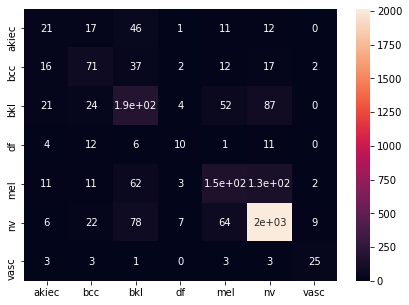

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
label = le.inverse_transform([0,1,2,3,4,5,6])
cm = confusion_matrix(y_test, SVM_prediction)
cm_df = pd.DataFrame(cm,label,label)                      
plt.figure(figsize=(7,5))  
sns.heatmap(cm_df, annot=True)
